In [43]:
import scanpy as sc
import numpy as np
from scipy import sparse
import pandas as pd
import torch
import scvi

import matplotlib.pyplot as plt
import matplotlib

In [44]:
adata_2019 = sc.read("/storage/groups/ml01/workspace/dominik.klein/pancreas_2019/GSE132188_adata.h5ad.h5")

/home/icb/dominik.klein/miniconda3/envs/moscot_env/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/icb/dominik.klein/miniconda3/envs/moscot_env/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [45]:
adata_2022 = sc.read("/storage/groups/ml01/workspace/dominik.klein/scMultiome_NVF/scMultiome_NVF_E14-E15/E14-E15_adata_filtered_rmDoublets_sctNormalized_WNN_embedded_initialAnno.h5ad")

In [46]:
adata = adata_2022.copy()

In [47]:
adata_2019.obs["prior_celltype"] = np.where(~pd.isnull(adata_2019.obs["clusters_fig6_alpha_final"]), adata_2019.obs["clusters_fig6_alpha_final"], adata_2019.obs["clusters_fig3_final_noep"])

In [48]:
adata.obs["prior_celltype"] = "Unknown"

In [49]:
adata_conct = adata.concatenate(adata_2019, join="outer")

/home/icb/dominik.klein/miniconda3/envs/moscot_env/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/icb/dominik.klein/miniconda3/envs/moscot_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [51]:
scvi.model.SCVI.setup_anndata(adata_conct, batch_key="batch", labels_key="prior_celltype")

/home/icb/dominik.klein/miniconda3/envs/moscot_env/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [52]:
scvi_model = scvi.model.SCVI(adata_conct, n_latent=30, n_layers=2)

In [53]:
scvi_model.train(100)

/home/icb/dominik.klein/miniconda3/envs/moscot_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 

Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/home/icb/dominik.klein/miniconda3/envs/moscot_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/100: 100%|██████████| 100/100 [16:28<00:00,  9.89s/it, loss=6.22e+03, v_num=1]


In [54]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

/home/icb/dominik.klein/miniconda3/envs/moscot_env/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [55]:
scanvi_model.train(25)

INFO     Training for 25 epochs.                                                             


/home/icb/dominik.klein/miniconda3/envs/moscot_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 

Epoch 1/25:   0%|          | 0/25 [00:00<?, ?it/s]

/home/icb/dominik.klein/miniconda3/envs/moscot_env/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/25: 100%|██████████| 25/25 [09:22<00:00, 22.50s/it, loss=6.33e+03, v_num=1]


In [17]:
adata_conct.obs["C_scANVI"] = scanvi_model.predict(adata_conct)
adata_conct.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata_conct)

In [18]:
sc.pp.neighbors(adata_conct, use_rep="X_scANVI")
sc.tl.umap(adata_conct)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


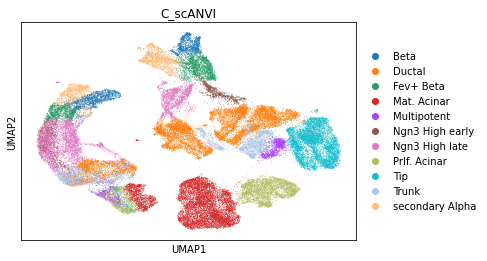

In [20]:
sc.pl.umap(adata_conct, color=['C_scANVI'])

In [21]:
adata_conct.obs["C_scANVI"]

AAACAGCCAACAGCCT-1-0-0               Beta
AAACAGCCAACCCTCC-1-0-0          Fev+ Beta
AAACAGCCACCTGTAA-1-0-0                Tip
AAACAGCCACTAAGCC-1-0-0          Fev+ Beta
AAACAGCCAGGATAAC-1-0-0     Ngn3 High late
                               ...       
TTTGTCAGTTGTTTGG-1-3-1             Ductal
TTTGTCATCCTGCAGG-1-3-1        Mat. Acinar
TTTGTCATCGAATGCT-1-3-1    secondary Alpha
TTTGTCATCTGTTTGT-1-3-1    secondary Alpha
TTTGTCATCTTAACCT-1-3-1        Mat. Acinar
Name: C_scANVI, Length: 53329, dtype: category
Categories (11, object): ['Beta', 'Ductal', 'Fev+ Beta', 'Mat. Acinar', ..., 'Prlf. Acinar', 'Tip', 'Trunk', 'secondary Alpha']

In [37]:
# Number of correctly classified cells
(adata_conct[adata_conct.obs["batch"]=="1"].obs["C_scANVI"].astype("str") == adata_conct[adata_conct.obs["batch"]=="1"].obs["prior_celltype"].astype("str")).sum()/len(adata_2019)

0.8712827707628401

In [38]:
adata_2022_red = adata_conct[adata_conct.obs["batch"]=="0"].copy()

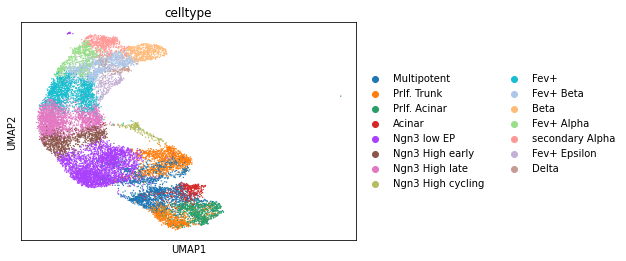

In [41]:
sc.pl.umap(adata_2022_red, color="celltype")

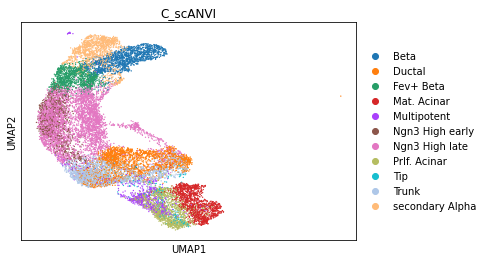

In [42]:
sc.pl.umap(adata_2022_red, color="C_scANVI")

In [33]:
adata_2019.obs["scanvi_pred"] = adata_conct.obs["C_scANVI"].astype("str")

In [35]:
(adata_2019.obs["scanvi_pred"] == adata_2019.obs["prior_celltype"]).sum()

0

In [40]:
adata_2022.obs.columns

Index(['n_counts', 'sample', 'int_id', 'reporter', 'log_cell_probs',
       'cell_barcodes_du', 'cell_barcodes_cr', 'cell_barcodes', 'log_counts',
       'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac',
       'total_counts_rank', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'leiden', 'orig.ident', 'nCount_RNA',
       'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal',
       'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile',
       'log_nCount_ATAC', 'log_nFeature_ATAC', 'scrublet_scores',
       'scrublet_doublets', 'scrublet_doublets_cat', 'dd_doublets',
       'dd_scores', 'dd_log_p_values', 'dd_voting_average', 'dd_-log_p_values',
       'dd_doublets_cat', 'pANN', 'DF_classifications_1',
       'DF_classifications_2', 'pANN_SCT', 'DF_SCT_classifications_1',
    

In [ ]:
#[adata_conct.obs["batch"]=="1"]

In [32]:
(adata_conct[adata_conct.obs["batch"]=="1"]).obs["day"]

AAACCTGAGCACCGCT-1-0-1    12.5
AAACCTGAGCGCTTAT-1-0-1    12.5
AAACCTGAGGGAAACA-1-0-1    12.5
AAACCTGAGGTACTCT-1-0-1    12.5
AAACCTGAGTCACGCC-1-0-1    12.5
                          ... 
TTTGTCAGTTGTTTGG-1-3-1    15.5
TTTGTCATCCTGCAGG-1-3-1    15.5
TTTGTCATCGAATGCT-1-3-1    15.5
TTTGTCATCTGTTTGT-1-3-1    15.5
TTTGTCATCTTAACCT-1-3-1    15.5
Name: day, Length: 36351, dtype: category
Categories (4, object): ['12.5', '13.5', '14.5', '15.5']

In [ ]:
(adata_conct.obs["C_scANVI"].astype("str") == adata_conct.obs["prior_celltype"].astype("str")).sum()